In [116]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, classification_report

import math

from collections import defaultdict

In [117]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/master_df_20191106.xlsx"
data = pd.read_excel(file)
df_master = pd.DataFrame(data).set_index('FIPS')

In [118]:
df_master.columns

Index(['PropSFHA', 'PropDG', 'AveLS', 'MaxDepth', 'HurTrack', 'PeakGust',
       'MaxSusta', 'StrVI', 'SeVI', 'Str+SeVI', 'SoVI', 'AveDepth', 'O_Ind',
       'R_Ind', 'PropSComm', 'R_I_No0', 'R_I_NoO', 'R_I_No0_NoO', 'cat_3q',
       'cat_4q', 'Count', 'R_DES', 'R_AFF', 'Ex_Q4_c'],
      dtype='object')

In [119]:
df_master.groupby('cat_4q').size()

cat_4q
0    217
1    225
2    223
3    217
dtype: int64

In [120]:
def choose_data(df_master, feature_list, target_list):
    choices = feature_list + target_list
    df = df_master[choices].copy()
    df.dropna(inplace = True)
    return df

In [121]:
# EXAMPLE:
feature_list = ['PropSFHA', 'PropDG', 'AveLS', 'HurTrack',
                'PeakGust', 'StrVI', 'SeVI', 'AveDepth', 'PropSComm']
target_list = ['cat_4q']

df = choose_data(df_master, feature_list, target_list)

In [122]:
def partition_data(df, target_str):
    y = df[target_str]
    df_x = df.drop(target_str, axis = 1)
    return y, df_x

In [123]:
# EXAMPLE:
target_str = 'cat_4q'
y, df_x = partition_data(df, target_str)

In [124]:
def split_the_data_stratify(df_x, y):
    x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
                                                        test_size=0.2, 
                                                        random_state=42,
                                                        stratify = df_master['cat_4q'])
    return x_train, x_test, y_train, y_test


In [125]:
# def split_the_data(df_x, y):
#     x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
#                                                         test_size=0.2, 
#                                                         random_state=42)
                                                        
#     return x_train, x_test, y_train, y_test

In [126]:
# Careful of Random State
# Change y_binned to y if categorical
# EXAMPLE:
x_train, x_test, y_train, y_test = split_the_data_stratify(df_x, y)

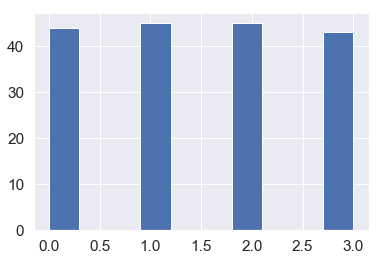

In [128]:
y_test.hist()

# Start with RF Classifier then syphon into multiple regressions

In [129]:
def randomized_cv(x_train, y_train, model):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = model
    # Random search of parameters, using cv = cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_randomized_cv = RandomizedSearchCV(estimator = rf, 
                                          param_distributions = random_grid, 
                                          n_iter = 100, 
                                          cv = 5, 
                                          verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)
    
    # Fit the random search model
    rf_randomized_cv.fit(x_train, y_train)
    
    print(rf_randomized_cv.best_params_)
    return rf_randomized_cv.best_estimator_
    

In [130]:
#EXAMPLE
#Random state
#CHOOSE IF REGRESSOR OR CLASSIFICATION
random_tuned_model_class = randomized_cv(x_train, y_train, RandomForestClassifier())

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, total=   5.5s
[CV] n_estimators=1788, min_sa

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.3s


[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.6s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.6s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.6s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, total=   5.1s
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, total=   5.1s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV] n_estimators=1577, min_samples_

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min


[CV]  n_estimators=1155, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, total=   3.7s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=1155, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, total=   3.7s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=1155, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, total=   3.8s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.7s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.7s
[CV] n_estimators=522, min_samp

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.7min


[CV]  n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, total=   2.4s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   5.1s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   5.1s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   5.3s
[CV] n_estimators=944, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40 
[CV]  n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, total=   2.3s
[CV] n_estimators=944, min_samples_spli

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.7min finished


{'n_estimators': 1577, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100}


In [131]:
random_tuned_model_class.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1577, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [132]:
def grid_cv(x_train, y_train, model):
    param_grid = {
        'max_depth': [20, 30, 50, 100],
        'max_features': [2, 3, 4],
        'min_samples_leaf': [1, 3, 5],
        'min_samples_split': [2, 3, 5],
        'n_estimators': [1000, 2000]
    }
    # Create a based model
    rf = model
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, 
                               param_grid = param_grid, 
                               cv = 5, n_jobs = -1, 
                               verbose = 2)
    grid_search.fit(x_train, y_train)
    
    print(grid_search.best_params_)
    return grid_search.best_estimator_

In [133]:
#Example
#CHOOSE IF REGRESSOR OR CLASSIFICATION
tuned_model_class = grid_cv(x_train, y_train, RandomForestClassifier())

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=2000 
[CV] max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=2000 
[CV] max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=2000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   2.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=1, min_samples

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.5s


[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total=   2.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total=   2.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total=   2.6s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=2000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=2000, total=   5.2s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=2000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=2000, total=   5.2s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_spl

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min


[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=2000, total=   6.4s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=2, n_estimators=2000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=2000, total=   6.4s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=2, n_estimators=2000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=2000, total=   6.4s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=2, n_estimators=2000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=2000, total=   6.4s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=3, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=2, n_estimators=1000, total=   3.1s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_spl

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.8min


[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=2000 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=3, n_estimators=2000, total=   9.8s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=2000 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=3, n_estimators=2000, total=   9.8s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=2000 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=3, n_estimators=2000, total=   9.9s
[CV] max_depth=30, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estimators=1000, total=   4.6s
[CV] max_depth=30, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, n_estima

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  8.0min


[CV]  max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   3.7s
[CV] max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=1000 
[CV]  max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   4.1s
[CV] max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=1000 
[CV]  max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, total=   5.1s
[CV] max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=1000 
[CV]  max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, total=   5.1s
[CV] max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=1000 
[CV]  max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, total=   4.9s
[CV] max_depth=50, max_features=3, min_samples_leaf=1, min_samples_spl

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 12.2min


[CV]  max_depth=100, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, total=   3.9s
[CV] max_depth=100, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=2000 
[CV]  max_depth=100, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   7.7s
[CV] max_depth=100, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=2000 
[CV]  max_depth=100, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   7.6s
[CV] max_depth=100, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=2000 
[CV]  max_depth=100, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   7.7s
[CV] max_depth=100, max_features=4, min_samples_leaf=1, min_samples_split=3, n_estimators=2000 
[CV]  max_depth=100, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   7.8s
[CV] max_depth=100, max_features=4, min_samples_leaf=1, min_s

[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 13.1min finished


{'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}


In [134]:
tuned_model_class.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [138]:
hypertune_model_class = tuned_model_class.fit(x_train, y_train)

In [140]:
def prediction(model, x_train, x_test):
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)   
    return pred_train, pred_test

In [141]:
# EXAMPLE
#CHOOSE MODEL
pred_train, pred_test = prediction(hypertune_model_class, x_train, x_test)

In [142]:
def evaluate_classification(model, x_train, x_test, y_train, y_test):
    pred = model.predict(x_test)
    accuracy_train = model.score(x_train, y_train)
    print('The mean training accuracy is {}'.format(accuracy_train))
    accuracy_test = model.score(x_test, y_test)
    print('The mean test accuracy is {}'.format(accuracy_test))
    df_confusion = pd.DataFrame(confusion_matrix(y_test, pred))
    print(df_confusion)
    print(classification_report(y_test, pred))
    return df_confusion

In [144]:
# EXAMPLE
# CHOOSE MODEL IF WANT TUNED OR JUST CLASSIFICATION WITH DEFAULT
df_confusion = evaluate_classification(hypertune_model_class, x_train, x_test, y_train, y_test)

The mean training accuracy is 1.0
The mean test accuracy is 0.4293785310734463
    0   1   2   3
0  20  10   5   9
1   9  17  10   9
2  11  15  10   9
3   3   2   9  29
             precision    recall  f1-score   support

          0       0.47      0.45      0.46        44
          1       0.39      0.38      0.38        45
          2       0.29      0.22      0.25        45
          3       0.52      0.67      0.59        43

avg / total       0.41      0.43      0.42       177



In [145]:
def plot_confusion(df_confusion):
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_confusion, cmap='PuBu', annot=True, annot_kws={"size": 16})# font size
    plt.ylabel('Predicted')
    plt.xlabel('True Value')
    plt.show()

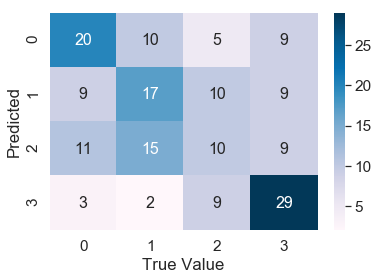

In [146]:
# EXAMPLE
plot_confusion(df_confusion)

In [147]:
def frames_for_regression(y_train, y_test, target):
    df_y_test_pred = pd.DataFrame(y_test)
    df_y_test_pred['cat_4q_pred'] = pred_test
    df_y_train = pd.DataFrame(y_train)

    Target = pd.DataFrame(target)

    Test_reg = x_test.merge(df_y_test_pred, right_index=True, left_index=True, how='left').merge(Target, right_index=True, left_index=True, how='left')

    Train_reg = x_train.merge(df_y_train, right_index=True, left_index=True, how='left').merge(Target, right_index=True, left_index=True, how='left')
    
    return Test_reg, Train_reg

In [148]:
target = df_master['R_Ind']
Test_reg, Train_reg = frames_for_regression(y_train, y_test, target)

In [149]:
def merge_class_results(x_train,x_test,y_train,y_test):
    df_y_test_pred = pd.DataFrame(y_test)
    df_y_test_pred['cat_4q_pred'] = pred_test

    df_y_train_pred = pd.DataFrame(y_train)
    df_y_train_pred['cat_4q_pred'] = pred_train
    
    df_class_results = df_y_train_pred.append(df_y_test_pred)
    df_class_results.drop(['cat_4q'], axis=1, inplace=True)
    
    df_master_results = df_master.merge(df_class_results, right_index=True, left_index=True, how='left')
    df_master_results.drop(['O_Ind', 'R_I_No0', 'R_I_NoO', 'R_I_No0_NoO', 'cat_3q','R_DES', 'R_AFF', 'Ex_Q4_c'], axis=1, inplace=True)
    
    return df_master_results

In [150]:
#EXAMPLE
df_master_results = merge_class_results(x_train,x_test,y_train,y_test)

### Divide into 2 sets for 2 regressions: bottom 3 quartiles and top quartile

In [151]:
Train_reg.head()

,PropSFHA,PropDG,AveLS,HurTrack,PeakGust,StrVI,SeVI,AveDepth,PropSComm,cat_4q,R_Ind
FIPS,,,,,,,,,,,
72025201600,0.00,0.01,1.00,0.11,58.12,-2.66,-0.58,0.35,0.374465,2,0.035413
72021031101,0.00,0.00,1.00,0.16,58.56,-0.18,8.28,0.00,0.001675,1,0.013477
72041240602,0.01,0.00,1.29,0.02,54.99,5.03,6.39,0.00,0.013273,1,0.011466
72043954000,0.00,0.00,1.21,0.16,50.52,-0.06,1.26,0.00,0.002270,3,0.124171
72031051102,0.00,0.00,1.00,0.27,60.80,0.64,1.28,0.00,0.000421,3,0.071468


In [152]:
def split_by_quartile(Train_reg, Test_reg):
    Train_reg_l = Train_reg[Train_reg['cat_4q'] < 3]
    Train_reg_h = Train_reg[Train_reg['cat_4q'] == 3]
    
    Test_reg_l = Test_reg[Test_reg['cat_4q_pred'] < 3]
    Test_reg_h = Test_reg[Test_reg['cat_4q_pred'] == 3]
    
    return Train_reg_l,Train_reg_h,Test_reg_l,Test_reg_h

In [153]:
Train_reg_l,Train_reg_h,Test_reg_l,Test_reg_h = split_by_quartile(Train_reg, Test_reg)

In [154]:
def choose_data_high_low(Train_reg_l,Train_reg_h,Test_reg_l,Test_reg_h, feature_list, target_list):
    #choices = feature_list + target_list
    x_train_l = Train_reg_l[feature_list].copy()
    x_test_l = Test_reg_l[feature_list].copy()
    y_train_l = Train_reg_l[target_list].copy()
    y_test_l = Test_reg_l[target_list].copy()
    
    x_train_h = Train_reg_h[feature_list].copy()
    x_test_h = Test_reg_h[feature_list].copy()
    y_train_h = Train_reg_h[target_list].copy()
    y_test_h = Test_reg_h[target_list].copy()
    
    x_train_l.dropna(inplace=True)
    x_test_l.dropna(inplace=True)
    y_train_l.dropna(inplace=True)
    y_test_l.dropna(inplace=True)
    x_train_h.dropna(inplace=True)
    x_test_h.dropna(inplace=True)
    y_train_h.dropna(inplace=True)
    y_test_h.dropna(inplace=True)
    
    y_train_l = y_train_l.values.ravel()
    y_test_l = y_test_l.values.ravel()
    y_train_h = y_train_h.values.ravel()
    y_test_h = y_test_h.values.ravel()
        
    return x_train_l, x_test_l, y_train_l, y_test_l, x_train_h, x_test_h, y_train_h, y_test_h

In [155]:
# EXAMPLE:
#Consider keeping 'cat_4q' in low model for stratified sampling
feature_list = ['PropSFHA', 'PropDG', 'AveLS', 'HurTrack',
                'PeakGust', 'StrVI', 'SeVI', 'AveDepth', 'PropSComm']
target_list = ['R_Ind']

x_train_l, x_test_l, y_train_l, y_test_l, x_train_h, x_test_h, y_train_h, y_test_h = choose_data_high_low(Train_reg_l,Train_reg_h,Test_reg_l,Test_reg_h, feature_list, target_list)

In [156]:
#EXAMPLE
#Random state
#CHOOSE IF REGRESSOR OR CLASSIFICATION
random_tuned_model_l = randomized_cv(x_train_l, y_train_l, RandomForestRegressor())

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, total=   4.1s
[CV] n_estimators=1788, min_sa

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.8s


[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.6s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.6s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.6s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, total=   5.2s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, total=   5.2s
[CV] n_estimators=1577, min_samples_

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min


[CV]  n_estimators=1155, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, total=   3.9s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, total=   5.4s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.7s
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, total=   5.4s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV] n_estimators=311, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.8s
[CV] n_estimators=311, min_sample

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.9min


[CV]  n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, total=   3.5s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   6.3s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   5.8s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   6.0s
[CV] n_estimators=944, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   6.0s
[CV] n_estimators=944, min_samples_split

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.1min finished


{'n_estimators': 1155, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [68]:
#EXAMPLE
#Random state
#CHOOSE IF REGRESSOR OR CLASSIFICATION
random_tuned_model_h = randomized_cv(x_train_h, y_train_h, RandomForestRegressor())

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, total=   3.3s
[CV] n_estimators=1788, min_sa

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s


[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.0s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.0s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, total=   1.0s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, total=   3.7s
[CV] n_estimators=1577, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100 
[CV]  n_estimators=1788, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, total=   3.6s
[CV] n_estimators=1577, min_samples_

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   43.8s


[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.7s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.7s
[CV] n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None 
[CV]  n_estimators=522, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, total=   1.7s
[CV] n_estimators=311, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, total=   5.8s
[CV] n_estimators=311, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, total=   5.9s
[CV] n_estimators=311, min_sample

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min


[CV]  n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, total=   1.9s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   3.8s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   3.7s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100 
[CV]  n_estimators=1577, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, total=   3.7s
[CV] n_estimators=944, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40 
[CV]  n_estimators=733, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, total=   1.8s
[CV] n_estimators=944, min_samples_spli

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished


In [69]:
random_tuned_model_l.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=733, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

In [70]:
random_tuned_model_h.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

In [71]:
def grid_cv(x_train, y_train, model):
    param_grid = {
        'max_depth': [20, 50, 70, 100],
        'max_features': [2, 3, 4],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [5, 7, 10],
        'n_estimators': [500, 1000]
    }
    # Create a based model
    rf = model
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, 
                               param_grid = param_grid, 
                               cv = 5, n_jobs = -1, 
                               verbose = 2)
    grid_search.fit(x_train, y_train)
    
    print(grid_search.best_params_)
    return grid_search.best_estimator_

In [72]:
#Example
#CHOOSE IF REGRESSOR OR CLASSIFICATION
tuned_model_l = grid_cv(x_train_l, y_train_l, RandomForestRegressor())

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   1.0s
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_spli

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s


[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500, total=   1.0s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500, total=   1.0s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   1.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   1.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   1.9s
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_spl

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.6s


[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.6s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.6s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.7s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.6s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   1.3s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min


[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=1000, total=   2.6s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=1000, total=   2.6s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.4s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.3s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV]  max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   1.4s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.8min


[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   1.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   1.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500, total=   1.7s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500, total=   1.8s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500, total=   1.8s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_e

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.5min


[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=500, total=   1.6s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=1000 
[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   3.6s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=1000 
[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   3.5s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=1000 
[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   3.5s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=1000 
[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   3.5s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_spli

[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  4.9min finished


{'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 1000}


In [73]:
#Example
#CHOOSE IF REGRESSOR OR CLASSIFICATION
tuned_model_h = grid_cv(x_train_h, y_train_h, RandomForestRegressor())

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   0.9s
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_spli

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s


[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   1.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500, total=   0.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500, total=   0.9s
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   1.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500, total=   0.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=5, n_estimators=1000 
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.5s


[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   1.1s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.2s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.2s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.2s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=5, n_estimators=1000 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.2s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min


[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=1000, total=   2.4s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=1000, total=   2.4s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=1000, total=   2.4s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.2s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, total=   1.2s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_spl

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.9min


[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.7s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   2.2s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   2.3s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500, total=   2.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500, total=   2.7s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=7, n

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.4min


[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=500, total=   1.2s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=1000 
[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   2.4s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=1000 
[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   2.4s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=1000 
[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   2.4s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=7, n_estimators=1000 
[CV]  max_depth=70, max_features=4, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, total=   2.5s
[CV] max_depth=70, max_features=4, min_samples_leaf=3, min_samples_spli

[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.7min finished


{'max_depth': 20, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}


In [74]:
tuned_model_l.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=7, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)>

In [99]:
tuned_model_h.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)>

In [104]:
hypertune_model_h = tuned_model_h.fit(x_train_h, y_train_h)
hypertune_model_l = tuned_model_l.fit(x_train_l, y_train_l)

In [106]:
# EXAMPLE
#CHOOSE MODEL
pred_train_l, pred_test_l = prediction(hypertune_model_l, x_train_l, x_test_l)

In [107]:
# EXAMPLE
#CHOOSE MODEL
pred_train_h, pred_test_h = prediction(hypertune_model_h, x_train_h, x_test_h)

In [108]:
def evaluate_regression(pred_train, pred_test, y_train, y_test):
    r_train = r2_score(y_train, pred_train)
    print('The training r-squared score is {}'.format(r_train))
    r_test = r2_score(y_test, pred_test)
    print('The testing r-squared score is {}'.format(r_test))
    meanabserrors_train = np.mean(abs(pred_train - y_train))
    print('The training mean absolute error is {}'.format(meanabserrors_train))
    meanabserrors_test = np.mean(abs(pred_test - y_test))
    print('The testing mean absolute error is {}'.format(meanabserrors_test))
    rmse = math.sqrt(mean_squared_error(y_test, pred_test))
    print('The root mean square error is {}'.format(rmse))
    mse = mean_squared_error(y_test, pred_test)
    print('The mean square error is {}'.format(mse))
    errors = pred_test - y_test
    meanerror = np.mean(errors)
    print('The mean error is {}'.format(meanerror))
    return errors

In [109]:
# EXAMPLE
errors_l = evaluate_regression(pred_train_l, pred_test_l, y_train_l, y_test_l)

The training r-squared score is 0.6948198793499548
The testing r-squared score is 0.011376342258199501
The training mean absolute error is 0.00605291951359752
The testing mean absolute error is 0.015777131342238352
The root mean square error is 0.024054268063269227
The mean square error is 0.0005786078120596139
The mean error is -0.007708982776252237


In [110]:
# EXAMPLE
errors_h = evaluate_regression(pred_train_h, pred_test_h, y_train_h, y_test_h)

The training r-squared score is 0.3754991579678234
The testing r-squared score is -0.6339308037988605
The training mean absolute error is 0.020500843822080287
The testing mean absolute error is 0.04617704973862633
The root mean square error is 0.054884928699669995
The mean square error is 0.003012355398367859
The mean error is 0.032812327818884636


In [111]:
def plot_predictions(y_test, pred, Title):
    df_predictions = pd.DataFrame(y_test)
    df_predictions['Pred'] = pred
    X = df_predictions.iloc[:, 0].values.reshape(-1, 1)
    Y = df_predictions.iloc[:, 1].values.reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.scatter(X, Y, color='maroon')
    line = mlines.Line2D([0, 1], [0, 1], color='orange')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.xlabel("Damage Index")
    plt.ylabel("Precited Damage Index")
    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.title('Model Evaluation -' +  Title, fontsize = 20)
    plt.show()

### Why are there mixed values in the low and high sets?????? - Because it is going off of the predictions
### Break into 4 maybe? or 3?

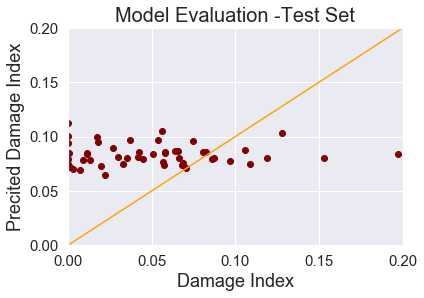

In [112]:
# EXAMPLE
Title = 'Test Set'
plot_predictions(y_test_h, pred_test_h, Title)

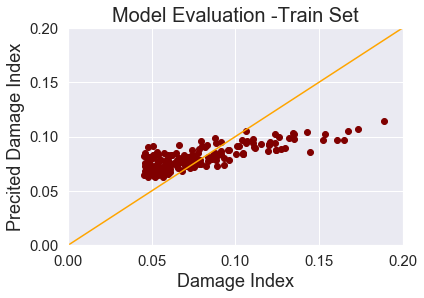

In [113]:
# EXAMPLE
Title = 'Train Set'
plot_predictions(y_train_h, pred_train_h, Title)

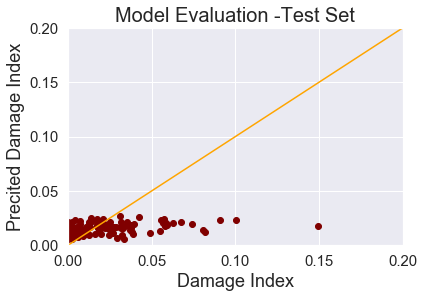

In [114]:
# EXAMPLE
Title = 'Test Set'
plot_predictions(y_test_l, pred_test_l, Title)

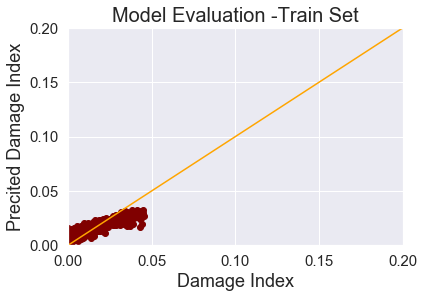

In [115]:
# EXAMPLE
Title = 'Train Set'
plot_predictions(y_train_l, pred_train_l, Title)

### Importances

In [164]:
def calc_gini_importances(x_train, model):
    importances = model.feature_importances_
    importances_df = pd.DataFrame(importances, x_train.columns,
                                  columns=['Importance']).sort_values('Importance',
                                  ascending=False)
    importances_df.reset_index(inplace=True)
    importances_df.rename(columns={'index':'Feature'}, inplace=True)
    return importances_df

In [165]:
# indicate if reg_model or class_model
# EXAMPLE
df_gini_importances_l = calc_gini_importances(x_train_l, reg_model_l)

In [166]:
# indicate if reg_model or class_model
# EXAMPLE
df_gini_importances_h = calc_gini_importances(x_train_h, reg_model_h)

In [167]:
def gini_importance_plot(df_gini_importances):
    df_gini_importances.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("Feature Importances", fontsize = 25)
    plt.ylabel('Importance', fontsize = 16)
    plt.xlabel('')
    plt.xticks(fontsize = 16, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
    

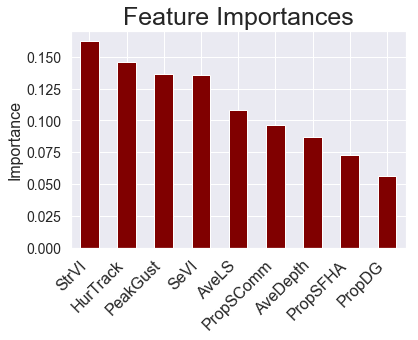

In [168]:
# EXAMPLE
gini_importance_plot(df_gini_importances_l)

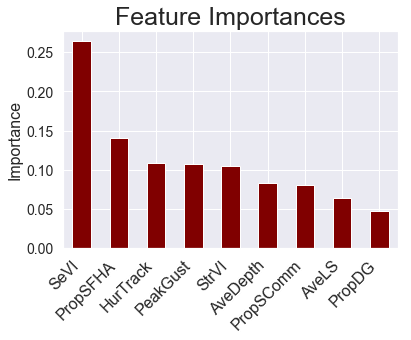

In [169]:
gini_importance_plot(df_gini_importances_h)